In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import glob

In [2]:
# 读取数据
(x_train,y_train),(x_test,_)=tf.keras.datasets.mnist.load_data()
print(x_train.shape,y_train.shape,x_train.dtype)

# 转换数据类型
x_train=((x_train.astype('float32')-127.5)/127.5).reshape(x_train.shape[0],28,28,1)
print(x_train.shape)

#  定义datasets
batch_szie=256
shuffle_size=60000

datasets=tf.data.Dataset.from_tensor_slices(x_train).shuffle(shuffle_size).batch(batch_szie)

(60000, 28, 28) (60000,) uint8
(60000, 28, 28, 1)


In [3]:
def generator_model():
    model=keras.Sequential()
    model.add(layers.Dense(256,input_shape=(100,),use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(512,use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(28*28*1,use_bias=False,activation='tanh'))
    model.add(layers.BatchNormalization())

    model.add(layers.Reshape((28,28,1)))
    
    return model

def discriminator_model():
    model=keras.Sequential()
    model.add(layers.Flatten())
    
    model.add(layers.Dense(512,use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(256,use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(1))
    
    return model

In [4]:
# 损失
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_image,fake_image):
    real_loss=cross_entropy(tf.ones_like(real_image),real_image)
    fake_loss=cross_entropy(tf.zeros_like(fake_image),fake_image)
    return real_loss+fake_loss

def generator_loss(fake_image):
    return cross_entropy(tf.ones_like(fake_image),fake_image)

# 优化器
generator_opti=tf.keras.optimizers.Adam(1e-4)
discriminator_opti=tf.keras.optimizers.Adam(1e-4)

# 参数
epochs=10
noise_dim=100
num_exp_to_generate=16
seed=tf.random.normal([num_exp_to_generate,noise_dim]) # 预测噪声

# 函数生成
generator=generator_model()
discriminator=discriminator_model()

In [5]:
@tf.function  # 函数修饰器,将用户定义的python风格的函数代码转化成高效的tensorflow计算图
                # 可以加速网络的推理速度,还能够有效降低占用显卡显存,使低显存的显卡也可以跑大网络
def train_step(images):
    '''梯度更新
    return: gen_loss,disc_loss
    '''
    noise=tf.random.normal([batch_szie,noise_dim])
    # 自动求解梯度
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_image=generator(noise,training=True)    # 输入噪声去生成图像并判别
        
        real_out=discriminator(images,training=True) # 输入真实图像去判别
        fake_out=discriminator(gen_image,training=True)
        
        gen_loss=generator_loss(fake_out)
        disc_loss=discriminator_loss(real_out,fake_out)
        
    gradient_gen=gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradient_disc=disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_opti.apply_gradients(zip(gradient_gen,generator.trainable_variables))
    discriminator_opti.apply_gradients(zip(gradient_disc,discriminator.trainable_variables))
    return gen_loss,disc_loss

In [6]:
def generator_plot_image(gen_model,test_noise):  # 
    pred_images=gen_model(test_noise,training=False) # 查看利用噪声数据生成出16的图像
    fig=plt.figure(figsize=(4,4))
    for i in range(pred_images.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((pred_images[i,:,:,0]+1)/2,cmap='gray') # 画出利用噪声数据gen出的图像
        plt.axis('off')
    plt.show()

In [7]:
def train(dataset,epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
            print('.',end='')
        generator_plot_image(generator,seed)
        print('将开始第{}轮epoch'.format(epoch+1))

...........................................................................................................................................................................................................................................

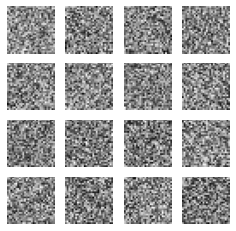

将开始第1轮epoch
...........................................................................................................................................................................................................................................

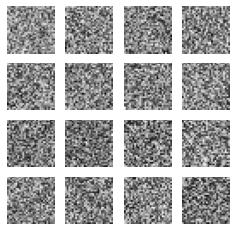

将开始第2轮epoch
...........................................................................................................................................................................................................................................

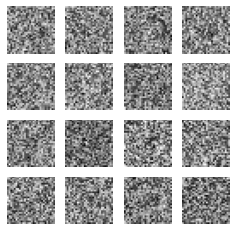

将开始第3轮epoch
...........................................................................................................................................................................................................................................

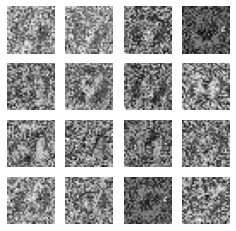

将开始第4轮epoch
...........................................................................................................................................................................................................................................

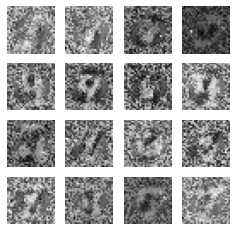

将开始第5轮epoch
...........................................................................................................................................................................................................................................

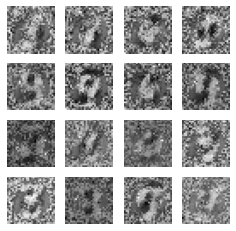

将开始第6轮epoch
...........................................................................................................................................................................................................................................

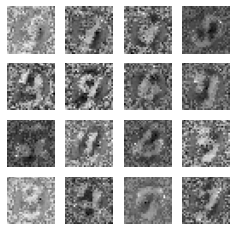

将开始第7轮epoch
...........................................................................................................................................................................................................................................

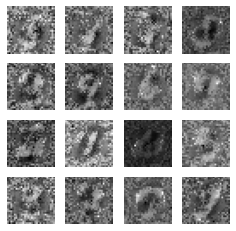

将开始第8轮epoch
...........................................................................................................................................................................................................................................

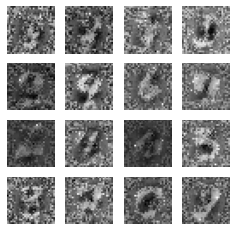

将开始第9轮epoch
...........................................................................................................................................................................................................................................

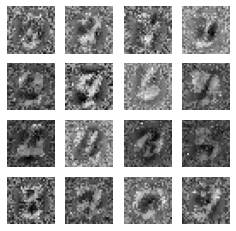

将开始第10轮epoch
共训练了10轮，每轮训练所用时间为3.602439522743225,总用时为36.02439522743225


In [8]:
import time
result1=time.time()

train(datasets,epochs)

# 输出每轮训练时间
result2=time.time()
print('共训练了{}轮，每轮训练所用时间为{},总用时为{}'
      .format(epochs,(result2-result1)/(epochs),result2-result1))